## Esercizio serie storica  

Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset data/globaltemperatures.csv, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

In [1]:
import pandas as pd
import sys
import os 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
sys.path.append('../')


In [2]:
globaltemperatures = pd.read_csv('data/globaltemperatures.csv')

In [3]:
globaltemperatures

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574
1,1750-02-01,3.083,3.702
2,1750-03-01,5.626,3.076
3,1750-04-01,8.490,2.451
4,1750-05-01,11.573,2.072
...,...,...,...
3187,2015-08-01,14.755,0.072
3188,2015-09-01,12.999,0.079
3189,2015-10-01,10.801,0.102
3190,2015-11-01,7.433,0.119


In [4]:
data = pd.read_csv('data/globaltemperatures.csv', parse_dates=['dt'], index_col='dt')
data = data[['LandAverageTemperature']]

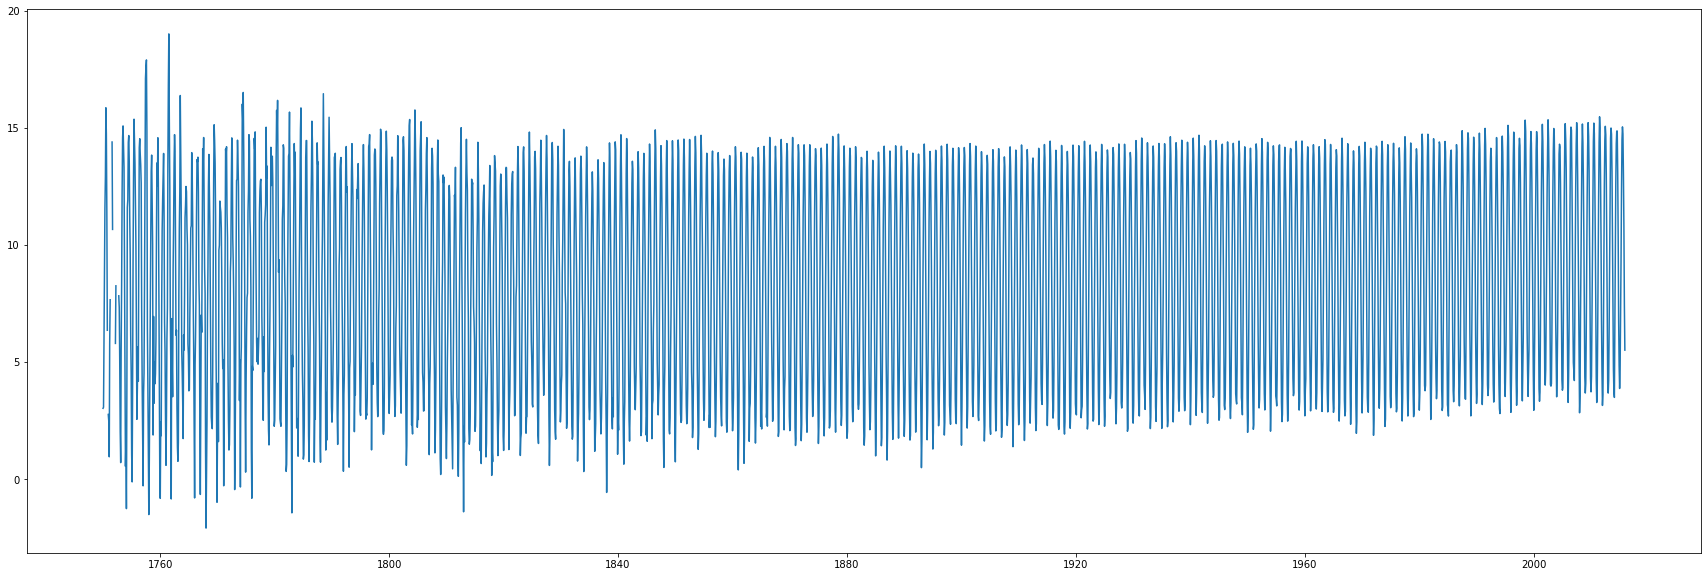

In [5]:
plt.figure(figsize=(30,10))
plt.plot(data.index, data.values)
plt.show()

La funzione Pandas dataframe.ffill() viene utilizzata per riempire il valore mancante nel dataframe. 'ffill' sta per 'riempimento in avanti' e propagherà l'ultima osservazione valida in avanti.

https://www.geeksforgeeks.org/python-pandas-dataframe-ffill/

## Gestione dei valori nulli

In [46]:
data_missing = data[data['LandAverageTemperature'].isnull()]
print("L'intervallo temporale dei valori nulli va dal " + str(data_missing.index.min()) + " al " + str(data_missing.index.max()) 
      + ".\nSi riportano i primi 10 valori nulli \n" + str(data_missing.head(10).reset_index()))

L'intervallo temporale dei valori nulli va dal 1750-11-01 00:00:00 al 1752-09-01 00:00:00.
Si riportano i primi 10 valori nulli 
          dt  LandAverageTemperature
0 1750-11-01                     NaN
1 1751-05-01                     NaN
2 1751-07-01                     NaN
3 1751-10-01                     NaN
4 1751-11-01                     NaN
5 1751-12-01                     NaN
6 1752-02-01                     NaN
7 1752-05-01                     NaN
8 1752-06-01                     NaN
9 1752-07-01                     NaN


Per fillare i valori nulli si è deciso si usare la tecnica classica **Forward Fill**. Questa tecnica prevede l'inserimento dell'ultimo valore disponibile per tutti i valori nulli, verrà propagato l'ultima osservazione valida per tutti i valori nulli

In [6]:
df_ffill = data.ffill()

In [8]:
result = adfuller(df_ffill.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.925122
p-value: 0.001858
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


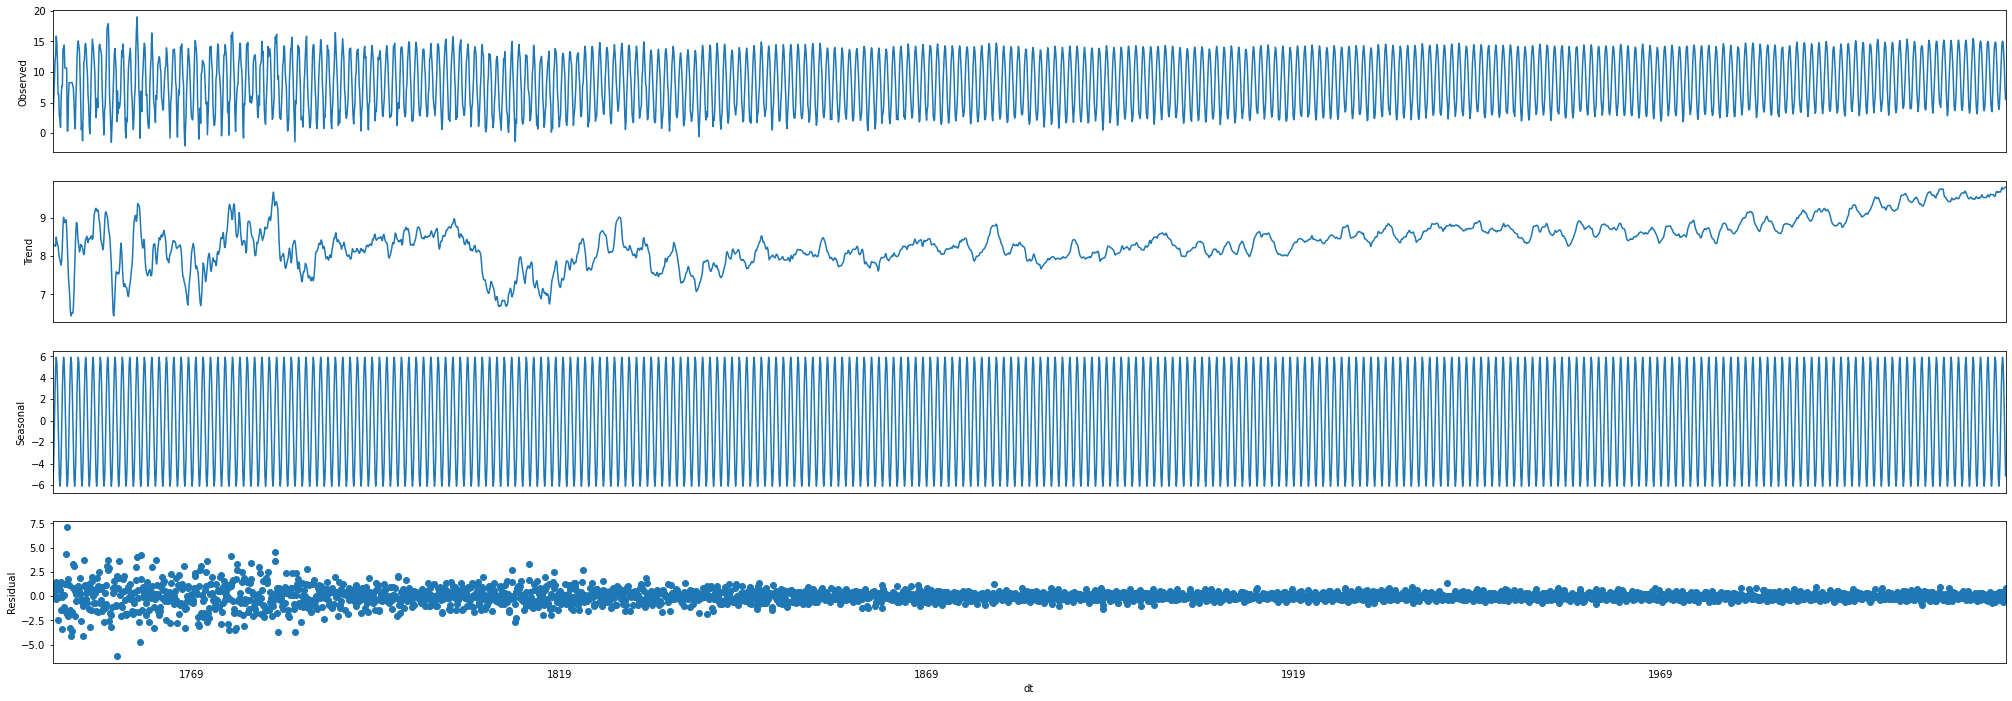

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
#from dateutil.parser import parse
result_add = seasonal_decompose(df_ffill['LandAverageTemperature'], model='additive', extrapolate_trend='freq')

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(35,12))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')
plt.show()

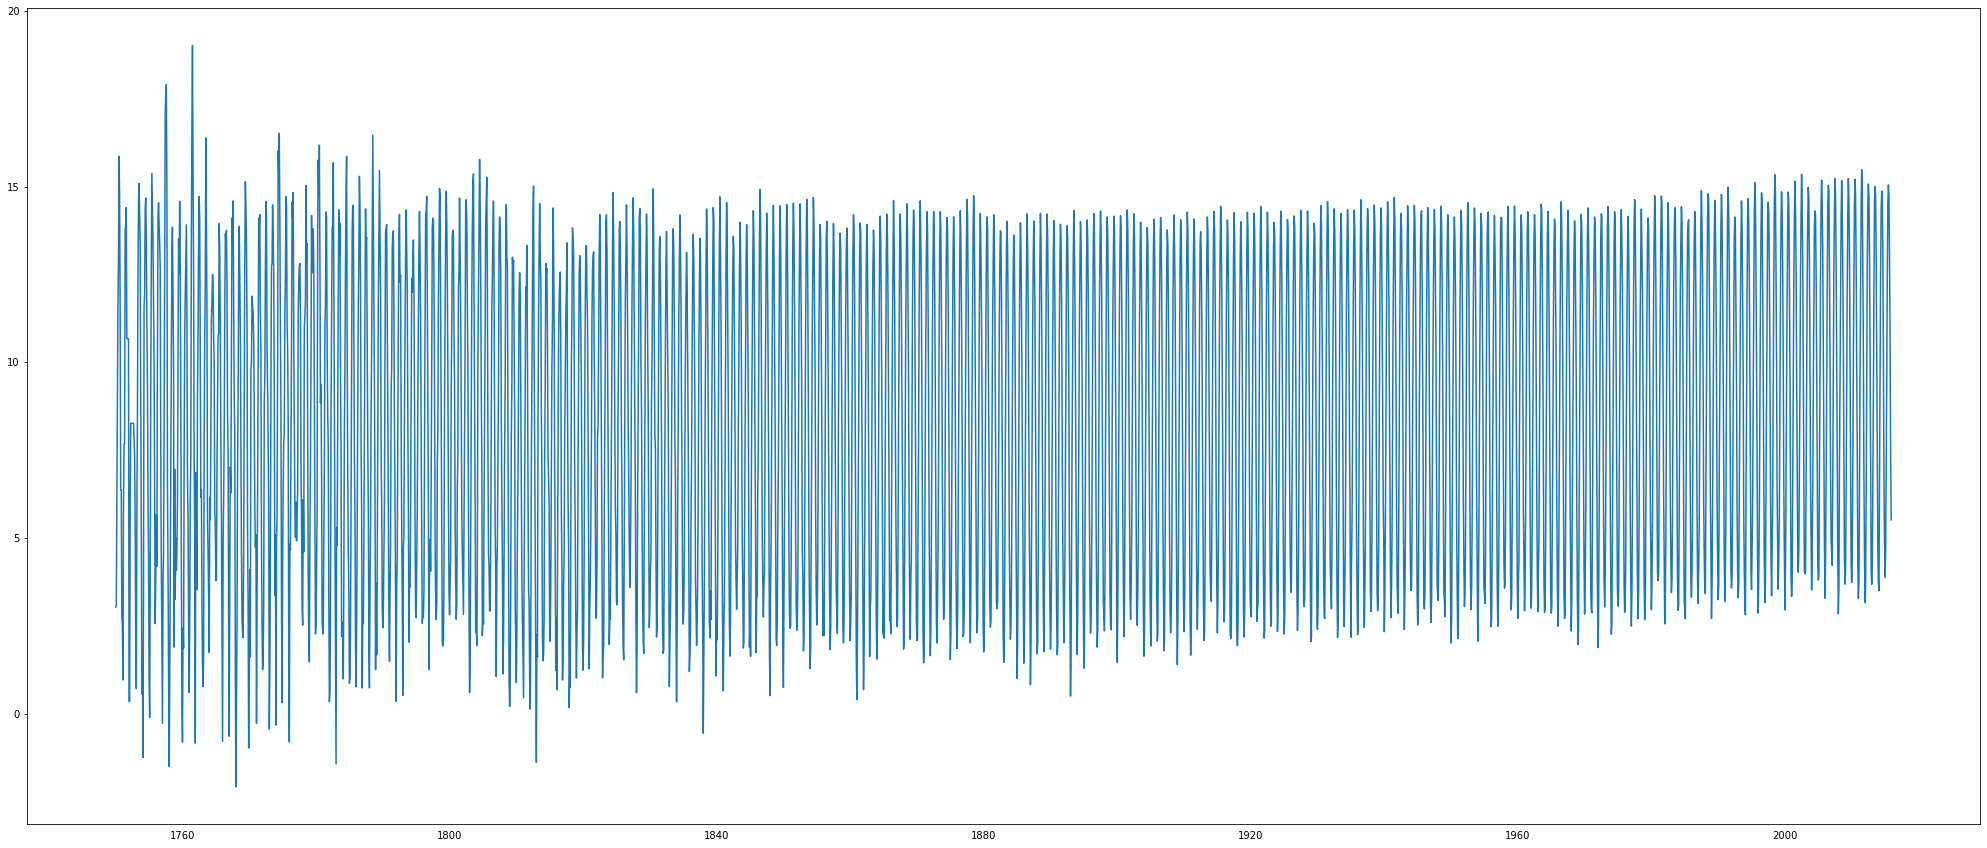

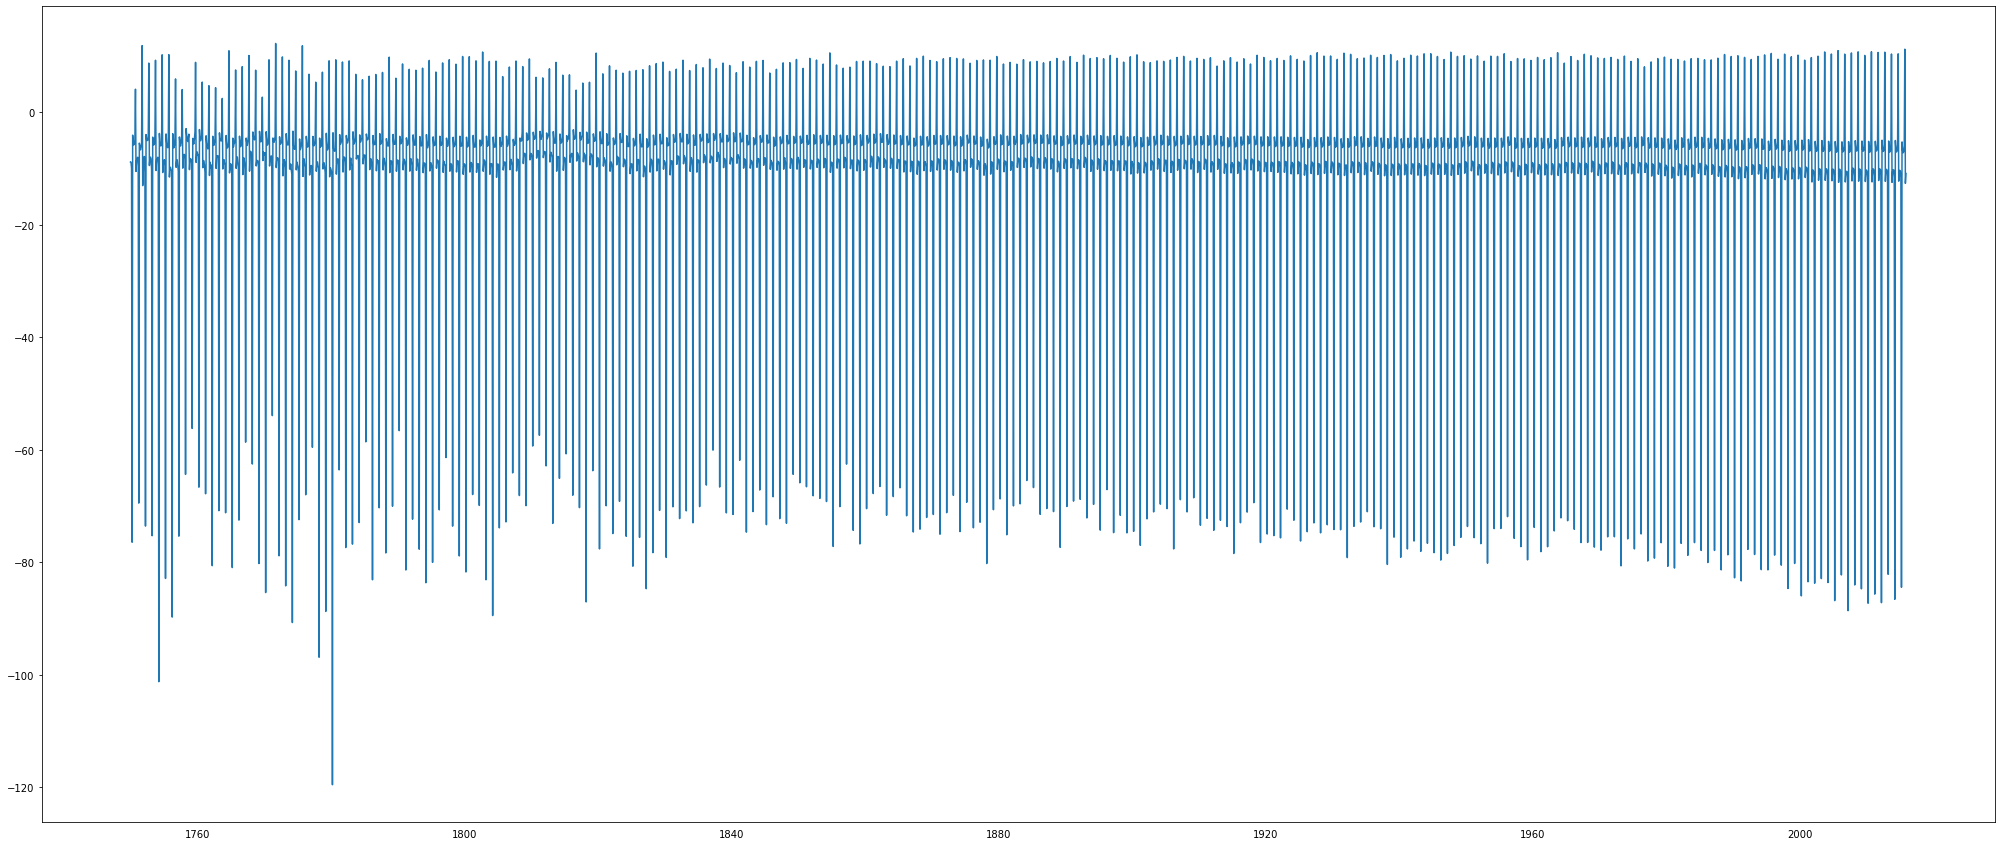

In [66]:
plt.rcParams.update({'figure.figsize': (35, 15)})

df_deseason_detrend = df_ffill.copy()
plt.plot(df_deseason_detrend.index, df_deseason_detrend)
plt.show()

from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df_deseason_detrend['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
deseasoned = df_deseason_detrend.LandAverageTemperature.values / result_mul.seasonal
deseasoned_detrended = deseasoned - result_mul.trend

plt.plot(df_deseason_detrend.index, deseasoned_detrended)
plt.show()

In [70]:
future_deseason_detrend = df_deseason_detrend[-24:]
past_deseason_detrend = df_deseason_detrend[:-24]

In [71]:
future = df_ffill[-24:]
past = df_ffill[:-24]

In [72]:
#!pip install pmdarima

In [ ]:
import pmdarima as pm

smodel = pm.auto_arima(past, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=21.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9652.364, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8480.305, Time=2.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9650.407, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9283.370, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8208.222, Time=6.55 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8615.177, Time=4.88 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8202.561, Time=7.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8475.612, Time=2.92 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=24.18 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.75 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=82

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(past.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(past)
plt.plot(future, color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()